# 1. 필요한 패키지 로드

In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
import os

import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))

Using TensorFlow backend.


tensorflow version: 2.1.0


# 2. 데이터셋 경로, 파라미터 선언

In [34]:
Path = './data/dataset'
epochs=50
batch_size = 16

# 3. 데이터셋  , 데이터 증식

In [35]:
imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=.1
)

trainGen = imageGenerator.flow_from_directory(
    os.path.join(Path, 'train'),
    batch_size = batch_size,
    target_size=(128, 128),
    subset='training'
)

validationGen = imageGenerator.flow_from_directory(
    os.path.join(Path, 'train'),
    batch_size = batch_size,
    target_size=(128, 128),
    subset='validation'
)
    

Found 334 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


# 5. 네트워크 설계

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()


model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu',input_shape=(128, 128, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(rate=0.25))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(rate=0.25))

model.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(rate=0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(2, activation='softmax'))



model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_21 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 64)       

In [50]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# 6. Training

In [51]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)
callbacks=[earlystop,learning_rate_reduction]

In [52]:
trainGen.samples

334

In [53]:
history = model.fit(
    trainGen, 
    epochs=epochs,
    steps_per_epoch= (trainGen.samples//batch_size),
    validation_data=validationGen
   ,callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 3 steps
Epoch 1/50
20/20 [==============================] - 24s 1s/step - loss: 1.4995 - accuracy: 0.6541 - val_loss: 6.7766 - val_accuracy: 0.6757
Epoch 2/50
20/20 [==============================] - 19s 938ms/step - loss: 0.7817 - accuracy: 0.7264 - val_loss: 17.8865 - val_accuracy: 0.6757
Epoch 3/50
20/20 [==============================] - 19s 937ms/step - loss: 0.5613 - accuracy: 0.7579 - val_loss: 25.3525 - val_accuracy: 0.6757
Epoch 4/50
20/20 [==============================] - 18s 921ms/step - loss: 0.5512 - accuracy: 0.7767 - val_loss: 34.5585 - val_accuracy: 0.6757
Epoch 5/50
20/20 [==============================] - 18s 899ms/step - loss: 0.5232 - accuracy: 0.8082 - val_loss: 43.5726 - val_accuracy: 0.6757
Epoch 6/50
19/20 [===========================>..] - ETA: 0s - loss: 0.4314 - accuracy: 0.8212
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20/20 [============

In [54]:
model.save("model.h5")

In [86]:
model = tf.keras.models.load_model('model.h5')

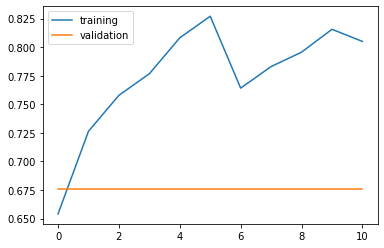

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [56]:
def show_graph(history_dict):
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 2))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

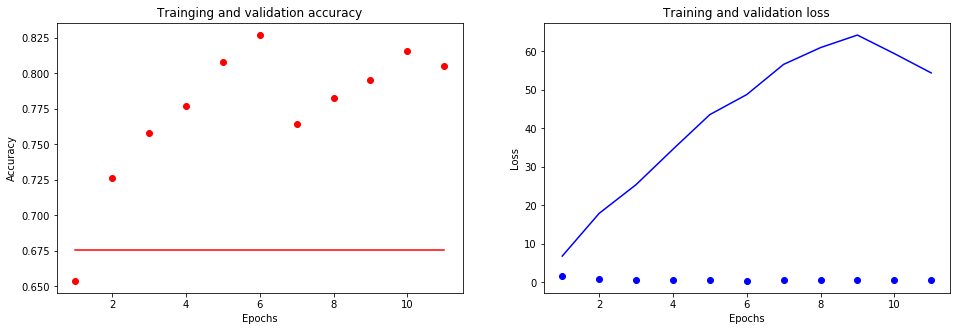

In [57]:
show_graph(history.history)

In [58]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    os.path.join(Path, 'test'),
    target_size=(128, 128)
)

Found 30 images belonging to 2 classes.


In [59]:
results = model.evaluate(testGen)
print('Test accuracy: ', results[1])

  ...
    to  
  ['...']
1/1 [==============================] - 1s 984ms/step - loss: 50.7719 - accuracy: 0.6667
Test accuracy:  0.6666667


예측: 충치
정답: 충치


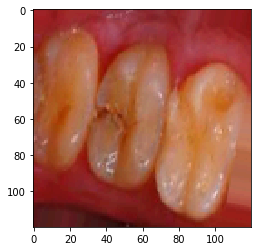

In [13]:
from tensorflow.keras.preprocessing.image import array_to_img

cls_index = ['충치', '정상치']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((120, 120))
result = model.predict_classes(arr.reshape(1, 120, 120, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))
plt.imshow(img)


In [ ]:
#faster-rcnn